In [ ]:
import os
import numpy as np
import torch
import pandas as pd
from rembg import new_session
import matplotlib.pyplot as plt    
import seaborn as sb
from sklearn import metrics
import scipy.stats as stats


# Set the working directory
os.chdir("..")
from utils.config import ROOT
os.chdir(ROOT)

import utils.BALROG_pipeline as bp

# Initialize the bgremove session
bg_session = new_session()

# Define the species arrays and the italicized versions for plotting
species_array = ['aegypti', 'albopictus', 'annulipes-group', 'caspius',
       'cataphylla', 'cinereus-geminus-pair', 'claviger-petragnani-pair',
       'communis-punctor-pair', 'japonicus', 'koreicus',
       'maculipennis s.l.', 'modestus', 'morsitans-fumipennis-pair',
       'other', 'pipiens s.l.-torrentium-pair', 'richiardii', 'rusticus',
       'stephensi', 'sticticus', 'vexans', 'vishnui-group']

species_italic = ['$\\it{Ae. aegypti}$','$\\it{Ae. albopictus}$',
                  '$\\it{Ae. japonicus}$','$\\it{Ae. koreicus}$',
                  '$\\it{An. maculipennis}$ s.l.','other',
                  '$\\it{Cx. torrentium-pipiens\\ }$s.l. pair',
                  '$\\it{Cq. richiardii}$','$\\it{An. stephensi}$',
                  '$\\it{Ae. vexans}$','$\\it{Cx. vishnui}$-group']

/Users/kristophernolte/miniforge3/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/kristophernolte/miniforge3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FF5E77A4-1F04-398B-B781-976783A281B8> /Users/kristophernolte/miniforge3/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/kristophernolte/miniforge3/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/kristophernolte/miniforge3/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/kristophernolte/miniforge3/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/kristophernolte/miniforge3/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wro

In [ ]:
# Load the images and paths
images = np.load(os.path.join("feasibility_experiment", "data", "images_zeiss.npy"))
paths = np.load(os.path.join("feasibility_experiment", "data", "paths_zeiss.npy"))

# Initialize dictionaries to store models and predictions
model_dict, prediction_dict = {}, {}

# Loop through all models 
for model in os.listdir(os.path.join("classifier", "models")):
    prediction_ls = []
    model_dict[model] = torch.load(os.path.join("classifier", "models", "{}".format(model)), map_location=torch.device('cpu'), weights_only=False)
    # Loop through all images
    for image in images:
        prediction = bp.get_model_prediction(model_dict[model], torch.tensor(image))
        prediction_ls.append(species_array[np.argmax(prediction)])

    # Save the predictions for the model in the dictionary
    prediction_dict[model] = prediction_ls

In [ ]:
# Transform the prediction dictionary to a DataFrame
dff = pd.DataFrame()
for key in prediction_dict.keys():
    df = pd.DataFrame()
    df["PRED"] = prediction_dict[key]
    df["Fold"] = key.split("_")[1]
    df["paths"] = paths

    dff = pd.concat([dff, df])

dff["file"] = dff["paths"].apply(lambda x: x.split("/")[-1])
dff["LABEL"] = dff["file"].apply(lambda x: x.split("_")[1])
dff["Participant"] = dff["paths"].apply(lambda x: x.split("/")[-2])

# Rename the image handles according to the proper LABEL
dff.loc[dff["LABEL"] == "namibi", "LABEL"] = "other"
dff.loc[dff["LABEL"] == "trit", "LABEL"] = "vishnui-group"
dff.loc[dff["LABEL"] == "pipiens", "LABEL"] = 'pipiens s.l.-torrentium-pair'
dff.loc[dff["LABEL"] == "maculipennis", "LABEL"] = 'maculipennis s.l.'
dff.loc[dff["LABEL"] == "richardii", "LABEL"] = 'richiardii'

# Create a column for correct predictions
dff["correct"] = dff["LABEL"] == dff["PRED"]

pd.to_pickle(dff, os.path.join("feasibility_experiment", "results", "feasibility_zeiss_df.pkl"))

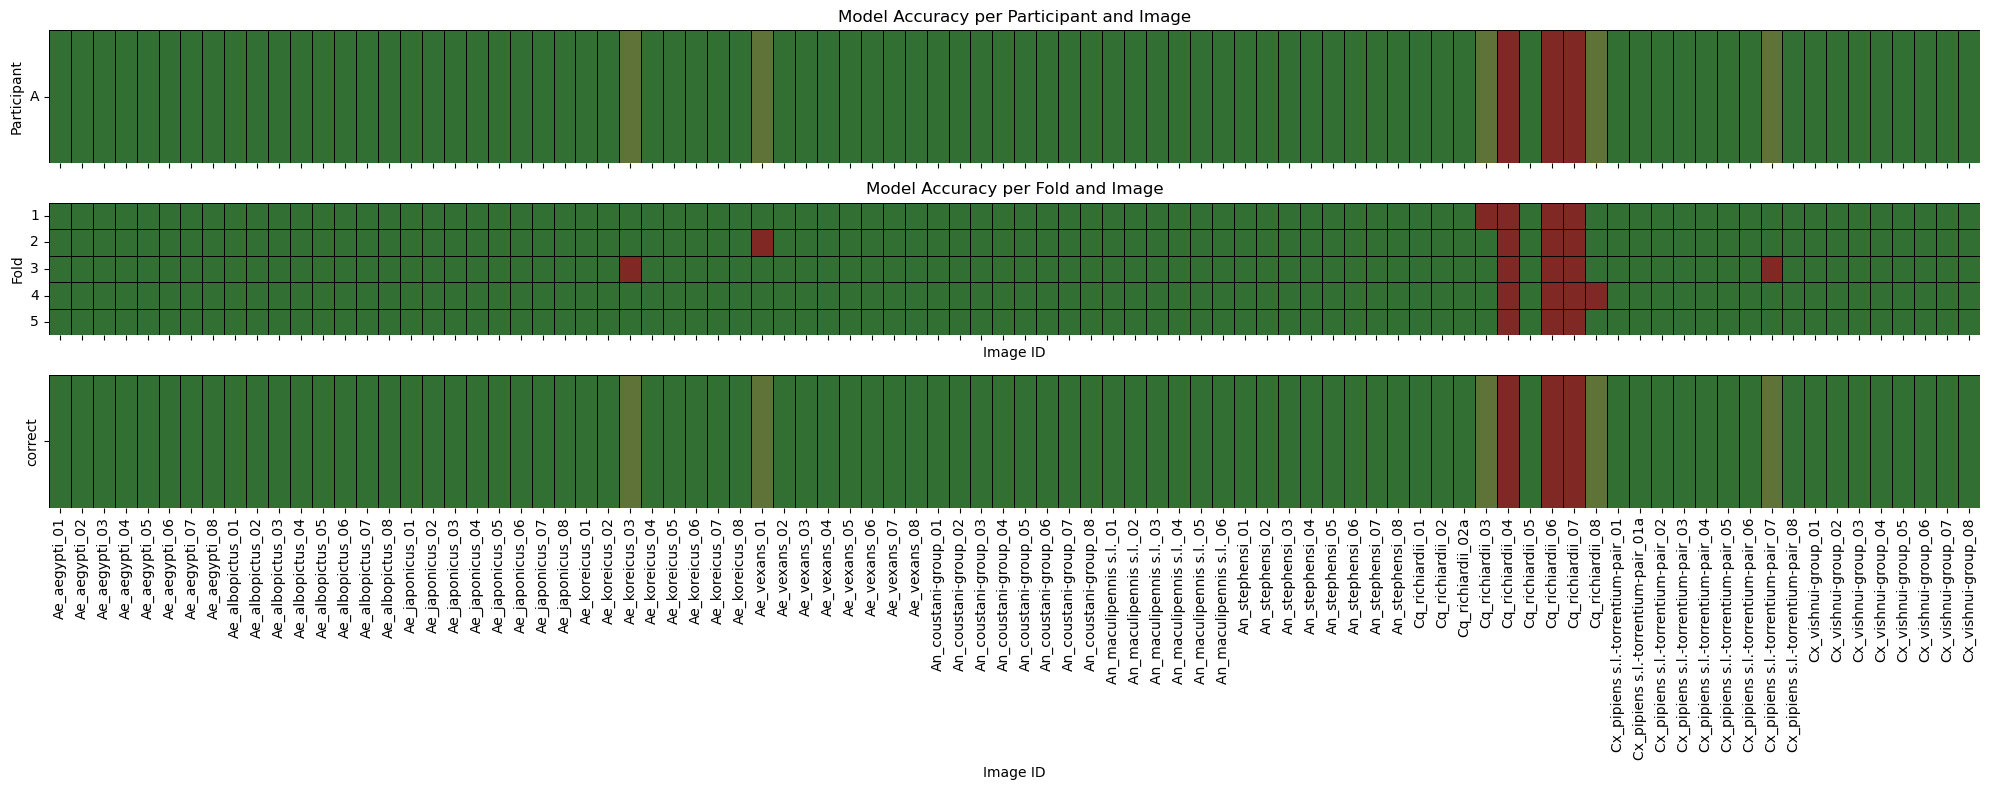

In [ ]:
# Plot the confusion matrix
DF = pd.read_pickle(os.path.join("feasibility_experiment", "results", "feasibility_zeiss_df.pkl"))

# Visualize the interrater realibaility
DF["Image ID"] = [x.split(".")[0] for x in DF["file"]]
DF["Image ID"] = DF["Image ID"].str.replace("namibi", "coustani-group")
DF["Image ID"] = DF["Image ID"].str.replace("trit", "vishnui-group")
DF["Image ID"] = DF["Image ID"].str.replace("pipiens", "pipiens s.l.-torrentium-pair")
DF["Image ID"] = DF["Image ID"].str.replace("maculipennis", "maculipennis s.l.")
DF["Image ID"] = DF["Image ID"].str.replace("richardii", "richiardii")
DF["Image ID"] = DF["Image ID"].str.capitalize()

# Create a heatmap where each unique image is one column and each participant is one row, the value of each cell should be the accuracy of the model
# Create a pivot table with participants as rows, images as columns, and accuracy as values
participant_table = DF.pivot_table(index='Participant', columns="Image ID", values='correct', aggfunc='mean')
fold_table = DF.pivot_table(index='Fold', columns="Image ID", values='correct', aggfunc='mean')
sum_table = DF.pivot_table(columns="Image ID", values='correct', aggfunc='mean')

# Costum palette for the heatmap
# Define the colors for the palette
colors = ["#802823", "#A27942", "#326F32"]
# Create the custom palette
red_custom_palette = sb.blend_palette(colors, as_cmap=True)

# Plot the heatmap
fig, ax = plt.subplots(3, figsize=(20, 8), sharex=True)
sb.heatmap(participant_table, cmap=red_custom_palette, ax=ax[0], linewidth=.5, vmax=1, linecolor="black", cbar=False)
sb.heatmap(fold_table, cmap=red_custom_palette, ax=ax[1], linewidth=.5, vmax=1, linecolor="black", cbar=False)
sb.heatmap(sum_table, cmap=red_custom_palette, ax=ax[2], linewidth=.5, vmax=1, linecolor="black", cbar=False)

ax[0].set_title('Model Accuracy per Participant and Image')
ax[1].set_title('Model Accuracy per Fold and Image')
plt.xticks(rotation=90)
ax[0].set_yticklabels(["A"], rotation=0)
ax[1].set_yticklabels(["1", "2", "3", "4", "5"], rotation=0)

ax[0].set_xlabel("")
plt.tight_layout()


<Axes: xlabel='PRED', ylabel='LABEL'>

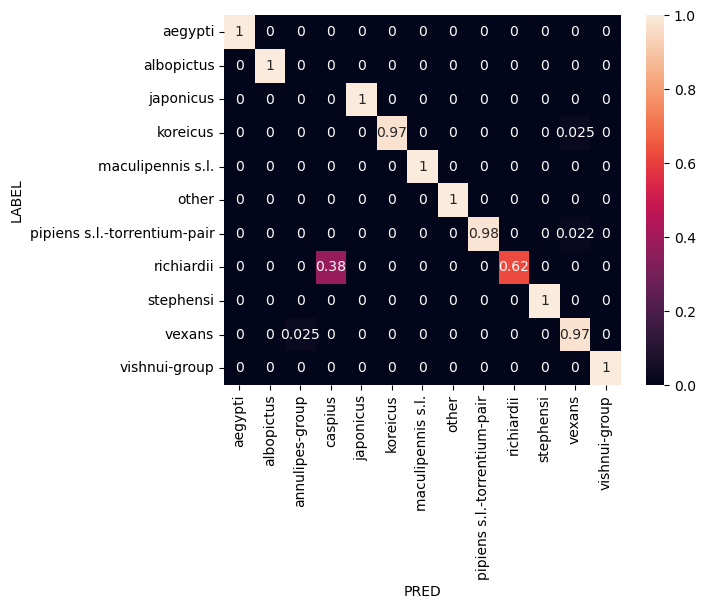

In [6]:
sb.heatmap(pd.crosstab(DF["LABEL"], DF["PRED"], normalize="index"), annot=True)

In [4]:
# Get the average balanced accuracy and F1 score for the model on the feasibility study
def get_avg_metric(df, with_ci = True):
    accuracy_ls, f1_ls = [], []
    for fold in df["Fold"].unique():
        df_fold = df.loc[df["Fold"] == fold]

        accuracy_ls.append(metrics.balanced_accuracy_score(df_fold["LABEL"], df_fold["PRED"]))
        f1_ls.append(metrics.f1_score(df_fold["LABEL"], df_fold["PRED"], average="macro"))

    acc_avg = np.mean(accuracy_ls)
    f1_avg = np.mean(f1_ls)

    if with_ci:
        acc_ci = stats.t.interval(0.95, len(accuracy_ls)-1, loc=np.mean(accuracy_ls), scale=stats.sem(accuracy_ls))
        f1_ci = stats.t.interval(0.95, len(f1_ls)-1, loc=np.mean(f1_ls), scale=stats.sem(f1_ls))
    

    return acc_avg*100, f1_avg*100, acc_ci, f1_ci

acc_avg, f1_avg, acc_ci, f1_ci = get_avg_metric(DF)
print(f"Accuracy: {acc_avg:.2f}% (95% CI: {acc_ci[0]*100:.2f}% - {acc_ci[1]*100:.2f}%)")
print(f"F1 Score: {f1_avg:.2f}% (95% CI: {f1_ci[0]*100:.2f}% - {f1_ci[1]*100:.2f}%)")

Accuracy: 95.91% (95% CI: 94.96% - 96.85%)
F1 Score: 87.83% (95% CI: 84.07% - 91.59%)


/Users/kristophernolte/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/kristophernolte/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/kristophernolte/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/kristophernolte/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/kristophernolte/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_tr